# Session selection helper for converting ADNI/PPMI dicoms to BIDS nifti.

This is how we select the most recent sessions of the subjects from PPMI and ADNI to get an elder population so that we have better matched control cohort for the local ET cohort.

In [1]:
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd

#PATH
main_dir = Path("/scratch")
out_dir = Path("/output")
code_dir = main_dir / 'ET_biomarker' / 'scripts' / 'heudiconv'
adni_dcm_file = code_dir/ 'heudiconv_res' / 'ADNI_dicomInfo.tsv'  # from dicom headers
ppmi_dcm_file = code_dir/ 'heudiconv_res' / 'PPMI_dicomInfo.tsv'  # from dicom headers
adni_dcm_folder_file = code_dir/ 'heudiconv_res' / 'ADNI_dcm_format4.csv' # from dicom folder names
adni_dl_file = main_dir / 'ET_biomarker' / 'tab_data' / '3T_T1_CN_ADNI2_7_15_2021.csv' # from download page
ppmi_dl_file = main_dir / 'ET_biomarker' / 'tab_data' / '3T_T1_NC_PPMI_5_08_2021.csv'  # from download page

# Read table
adni_full_data=pd.read_csv(adni_dcm_file, sep='\t')
ppmi_full_data=pd.read_csv(ppmi_dcm_file, sep='\t')
adni_dl_full_data=pd.read_csv(adni_dl_file, sep=',')
ppmi_dl_full_data=pd.read_csv(ppmi_dl_file, sep=',')
adni_folder_data=pd.read_csv(adni_dcm_folder_file, sep='\t',skip_blank_lines=1)

## ADNI dicom diagnosis 
Observed dicom header problems for age,sex and other columns. Need to fix age and sex manually.
The image_id and session id are not the same feature.
http://adni.loni.usc.edu/support/experts-knowledge-base/question/?QID=488
recommend not to use images with 
LONI image 58872 has 2 MPRAGE scans in the single series (332 slices) it fails protocol and image QC since it does not have 166 slices.
We would suggest that you use the MPRAGE Repeat scan LONI I58874 for that subject’s time-point.
MPRAGE or IR-FSPGR. for T1

In [2]:
pd.set_option('mode.chained_assignment','warn')
dcm_feature_list = ['patient_id','dcm_dir_name','date','series_id', 'sequence_name','series_description', 'protocol_name','dim1','dim2','dim3','dim4']
dl_feature_list = ['Subject','Image Data ID','Description','Acq Date','Sex','Age', 'Visit']

adni_dcm_data = adni_full_data[dcm_feature_list];  ppmi_dcm_data = ppmi_full_data[dcm_feature_list]
adni_dl_data  = adni_dl_full_data[dl_feature_list]; ppmi_dl_data = ppmi_dl_full_data[dl_feature_list]
# check download meta data and dcm information
display('dicom info:',len(adni_dcm_data))
display('download meta data info (all images including locolizer images):',len(adni_dl_data))

'dicom info:'

2284

'download meta data info (all images including locolizer images):'

7320

In [3]:
# Verify with downloaded dicom folders (protocol name and date included) due to missing information from dicom headers
adni_folder_data=pd.read_csv(adni_dcm_folder_file, sep='\t',skip_blank_lines=1)
adni_folder_data=adni_folder_data.dropna()
adni_folder_data=adni_folder_data.iloc[:,1:]
adni_folder_data=adni_folder_data.rename(columns={"Unnamed: 1": "patient_id", "Unnamed: 2":"series_description", 'Unnamed: 3':"date", "Unnamed: 4":"dcm_dir_name"})
adni_folder_data=adni_folder_data.reset_index()
#adni_folder_data.head()

# confirmation from 
df_tmp=adni_folder_data[(adni_folder_data['series_description'].str.contains('RAGE', regex=False))]# | \
                       # (adni_folder_data['series_description'].str.contains('SPGR', regex=False))]
#adni_dcm_data['dim3'].unique()
display(len(df_tmp['patient_id'].unique()))
display(len(adni_folder_data['patient_id'].unique()))

#adni_full_data[adni_full_data['dim3']>600].tail(5)
tmp_col1=df_tmp.groupby(['patient_id'])
A = tmp_col1['date'].transform(max)
df_tmp.loc[:,'last_session_time']=list(A)
#B
df_tmp = df_tmp[df_tmp['date']==df_tmp['last_session_time']]
#df_tmp['i_id']=df_tmp.index
#display(len(df_tmp))
df_tmp.sort_values(by='patient_id')
gX=df_tmp.groupby('patient_id')
g1X=gX['dcm_dir_name'].apply(lambda x: max(x))
display(g1X)
#g1.to_csv(adni_session_file,header=0)
len(g1X)

238

312

/usr/local/miniconda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/miniconda/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


patient_id
002_S_0295    S150056
002_S_0413    S322084
002_S_0685    S160107
002_S_1261    S262111
002_S_1280    S258723
               ...   
941_S_4100    S418036
941_S_4255    S205784
941_S_4292    S489268
941_S_4365    S437582
941_S_4376    S437616
Name: dcm_dir_name, Length: 238, dtype: object

238

In [4]:
#adni_dicom_counter_df=adni_folder_data[(adni_folder_data['series_description'].str.contains('MPRAGE', regex=False))]# | \
                       # (adni_folder_data['series_description'].str.contains('SPGR', regex=False))]
adni_dicom_counter_df=adni_folder_data[adni_folder_data['series_description']=='MPRAGE']# | \
adni_dl_counter_df= adni_dl_data[adni_dl_data['Description']=='MPRAGE']# | \
#adni_dl_counter_df= adni_dl_data[(adni_dl_data['Description'].str.contains('MPRAGE', regex=False))]# | \
                       # (adni_folder_data['series_description'].str.contains('SPGR', regex=False))]
display('MPRAGE: ADNI dicom: ',len(adni_dicom_counter_df['patient_id'].unique()))
display('ADNI download tab: ', len(adni_dl_counter_df['Subject'].unique()))

adni_dicom_counter_df=adni_folder_data[(adni_folder_data['series_description'].str.contains('RAGE', regex=False)) | \
                                       (adni_folder_data['series_description'].str.contains('SPGR', regex=False))]
adni_dl_counter_df= adni_dl_data[(adni_dl_data['Description'].str.contains('RAGE', regex=False)) | \
                                 (adni_dl_data['Description'].str.contains('SPGR', regex=False))]
display('*RAGE+*SPGR: ADNI dicom: ',len(adni_dicom_counter_df['patient_id'].unique()))
display(r'ADNI download tab: ', len(adni_dl_counter_df['Subject'].unique()))


'*RAGE: ADNI dicom: '

203

'ADNI download tab: '

203

'*RAGE+*SPGR: ADNI dicom: '

312

'ADNI download tab: '

312

In [18]:
# session information directly from dicom headers
df_tmp1=adni_dcm_data[#(adni_dcm_data['dim1']>190) & (adni_dcm_data['dim1']<300) & \
                     #(adni_dcm_data['dim2']>190) & (adni_dcm_data['dim2']<300) & \
                     #(adni_dcm_data['dim3']>100) & #(adni_dcm_data['dim3']<500) & \
                     ((adni_dcm_data['series_description'].str.contains('RAGE', regex=False)) | \
                      (adni_dcm_data['series_description'].str.contains('SPGR', regex=False)))]
#display(df_tmp)
#adni_dcm_data['dim3'].unique()
display(len(df_tmp1['patient_id'].unique()))
display(len(adni_dcm_data['patient_id'].unique()))
#display(tmp_col)
#adni_full_data[adni_full_data['dim3']>600].tail(5)
tmp_col1=df_tmp1.groupby(['patient_id'])
B = tmp_col1['date'].transform(max)
df_tmp1.loc[:,'last_session_time']=list(B)
#B
df_tmp1 = df_tmp1[df_tmp1['date']==df_tmp1['last_session_time']]
#df_tmp['i_id']=df_tmp.index
#display(len(df_tmp))
df_tmp1.sort_values(by='patient_id')
g2=df_tmp1.groupby('patient_id')
g3=g2['dcm_dir_name'].apply(lambda x: max(x))
display(g3)
#g3.to_csv(adni_session_file,header=0)
#len(g3)
#list(g3)
#adni_dcm_data[adni_dcm_data[] in list(g1)]

300

300

patient_id
002_S_0295    S110477
002_S_0413    S150697
002_S_0685    S114048
002_S_1261    S141746
002_S_1280    S183174
               ...   
941_S_4100    S418036
941_S_4255    S124668
941_S_4292    S489258
941_S_4365    S437573
941_S_4376    S437610
Name: dcm_dir_name, Length: 300, dtype: object

In [23]:
# save session names for further fMRIPrep use
def session2file(df, file_name, folder_name):
    df.to_csv(file_name, header=0)
    display(df.index)
    for x in df.index:
        f_path = out_dir / 'ADNI_sessions'  / x
        f = open(f_path, "w")
        f.write(df.loc[x])
        f.close()

adni_session_file = out_dir / 'ADNI_session.ses' # output: session we are going to process
session2file(g1X, adni_session_file, out_dir / 'ADNI_sessions' ) # g1X g3


Index(['002_S_0295', '002_S_0413', '002_S_0685', '002_S_1261', '002_S_1280',
       '002_S_4213', '002_S_4225', '002_S_4262', '002_S_4264', '002_S_4270',
       ...
       '153_S_4372', '941_S_1195', '941_S_1202', '941_S_1203', '941_S_4066',
       '941_S_4100', '941_S_4255', '941_S_4292', '941_S_4365', '941_S_4376'],
      dtype='object', name='patient_id', length=312)

In [20]:
# check all heuristic logic with sequence names from dicom header
#sequence_names = adni_dcm_data['series_description'].unique()
#for x in sequence_names:
#    if 'SPGR' in x:
#        print(x)
# check all 'MPRAGE' sequences
#sequence=adni_dcm_data['series_description'].unique()
#for x in sequence:
#    if 'MPRAGE' in x:
#        print(x)
# maybe better filter with this 
sequence_names = adni_dcm_data['series_description'].unique()
for x in sequence_names:
    if not (('SPGR' in x) or ('RAGE' in x)):
        print(x)

3 Plane Localizer
B-LOC
localizer
LOC
*SCOUT
localizer(VIT E R TEMPLE)
Localizer
localizer =
3 PLANE
Calibration Scan
B1-calibration Head
B1-calibration Body
B1-Calibration Body
B1-Calibration PA
SAG B1 CALIBRATION HEAD
Field Mapping
3-plane localizer
LOCALIZER
Cal 8HRBRAIN
SAG B1 CALIBRATION BODY
ADNI_gre_field_mapping
3 Plane Loc
SURVEY
3Plane Loc SSFSE
ASSET CALIBRATION
3-pl T2* FGRE
ADNI SH    SURVEY
Field Mapping_R/L
Average DC
T1 SAG
Field Mapping repeat
Cal Head+Neck 40
calibration scan
Field_mapping
3 PLANE LOCALIZER
B-LOC_S1_ND
SURV_NOPATCH_DEFSCALEPAR
B1-Calibration
LOCALIZER 3T
3-PL LOC
Cal Head 24
Survey
repeat SAG B1 CALIBRATION BODY


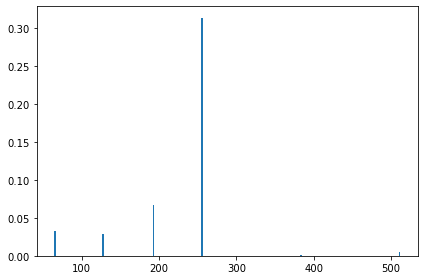

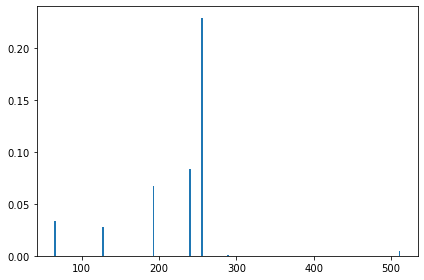

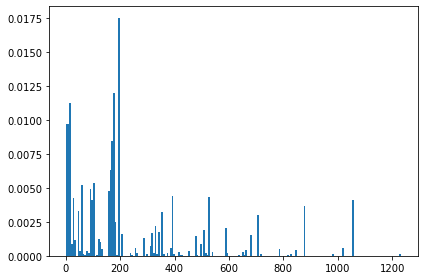

In [17]:
# check the image dimenion distribution
#display(ppmi_dl_data.sort_values(by='Subject', ascending=False).head())
#display(ppmi_dcm_data.sort_values(by='patient_id', ascending=False).head())
import seaborn as sns
import matplotlib.pyplot as plt

# the histogram of the data
fig, ax = plt.subplots()
n, bins, patches = ax.hist(adni_dcm_data['dim1'], 200, density=True)
# add a 'best fit' line
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()
fig, ax = plt.subplots()
n, bins, patches = ax.hist(adni_dcm_data['dim2'], 200, density=True)
# add a 'best fit' line
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()
fig, ax = plt.subplots()
n, bins, patches = ax.hist(adni_dcm_data['dim3'], 200, density=True)
# add a 'best fit' line
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

#sns.set_theme(style="darkgrid")
#sns.displot(
#    adni_dcm_data, x="dim3", row="series_description",
#    binwidth=3, height=3, facet_kws=dict(margin_titles=True),)